In [111]:
import pandas as pd

In [117]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [42]:
df = pd.read_csv('data/train_data_reduced.csv')
df = df.drop('Unnamed: 0', axis=1)
df_lab = pd.read_csv('data/train_labels_reduced.csv')[['customer_ID','target']]

In [43]:
df_with_labels = df.set_index('customer_ID').join(df_lab.set_index('customer_ID'))

In [44]:
cat_vars =  ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] 

## Plain Catboost

In [61]:
from catboost import CatBoostClassifier, Pool
import numpy as np
import sklearn.model_selection

In [62]:
labels = df_with_labels[['target']]

In [63]:
# Select training data
cols = df_with_labels.columns.tolist()
cols.remove('target')
cols.remove('S_2') # Statement Date?

# Handle NaN
data = df_with_labels[cols].copy()
cat_dtypes = data.dtypes[cat_vars]
data[cat_vars] = data[cat_vars].where(~data[cat_vars].isna(), 0)
data = data.astype({k: np.int32 for k in cat_dtypes[cat_dtypes == np.float64].keys()})
data_no_nan = data.replace(np.nan, "")

X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(data_no_nan, labels, test_size=.15)

# Training Pool
pool_train = Pool(X_train, y_train, cat_vars)
pool_val = Pool(X_val, y_val, cat_vars)

In [64]:
model = CatBoostClassifier(iterations=1800)
model.fit(pool_train, eval_set=pool_val, use_best_model=True,)

Learning rate set to 0.064988
0:	learn: 0.6259214	test: 0.6277300	best: 0.6277300 (0)	total: 121ms	remaining: 3m 37s
1:	learn: 0.5698376	test: 0.5732425	best: 0.5732425 (1)	total: 249ms	remaining: 3m 43s
2:	learn: 0.5287657	test: 0.5328413	best: 0.5328413 (2)	total: 349ms	remaining: 3m 28s
3:	learn: 0.4956962	test: 0.5003865	best: 0.5003865 (3)	total: 474ms	remaining: 3m 32s
4:	learn: 0.4655858	test: 0.4708818	best: 0.4708818 (4)	total: 599ms	remaining: 3m 35s
5:	learn: 0.4401447	test: 0.4455414	best: 0.4455414 (5)	total: 732ms	remaining: 3m 38s
6:	learn: 0.4176224	test: 0.4232664	best: 0.4232664 (6)	total: 839ms	remaining: 3m 34s
7:	learn: 0.4017945	test: 0.4077669	best: 0.4077669 (7)	total: 946ms	remaining: 3m 31s
8:	learn: 0.3886507	test: 0.3944830	best: 0.3944830 (8)	total: 1.06s	remaining: 3m 30s
9:	learn: 0.3779554	test: 0.3838080	best: 0.3838080 (9)	total: 1.17s	remaining: 3m 28s
10:	learn: 0.3670355	test: 0.3729986	best: 0.3729986 (10)	total: 1.29s	remaining: 3m 30s
11:	learn: 

# Feature Importances

In [67]:
model.feature_importances_
n_most_important = np.argsort(model.feature_importances_)[::-1]
n_most_important_vals = model.feature_importances_[n_most_important]
n_most_important_names = np.array(model.feature_names_)[n_most_important]
np.sum(n_most_important_vals)

100.00000000000003

In [131]:
delinquency_index = []
spend_index =[]
p_2_index=[]
payment_index = []
balance_index = []
risk_index = []
for i in range(len(n_most_important_names)):
    if n_most_important_names[i].startswith('D'):
        delinquency_index.append(i)
    elif n_most_important_names[i].startswith('S'):
        spend_index.append(i)   
    elif n_most_important_names[i] == 'P_2':
        p_2_index.append(i)
    elif n_most_important_names[i].startswith('P'):
        payment_index.append(i)
    elif n_most_important_names[i].startswith('B'):
        balance_index.append(i)   
    elif n_most_important_names[i].startswith('R'):
        risk_index.append(i)
    else:
        raise RuntimeError("no such thingy")

In [132]:
d_mean = np.mean(n_most_important_vals[delinquency_index])
s_mean = np.mean(n_most_important_vals[spend_index])
p_mean = np.mean(n_most_important_vals[payment_index])
p_2_mean = np.mean(n_most_important_vals[p_2_index])
b_mean = np.mean(n_most_important_vals[balance_index])
r_mean = np.mean(n_most_important_vals[risk_index])

In [133]:
names = ["P_2", "Delinquency", "Balance", "Payment", "Spend", "Risk"]

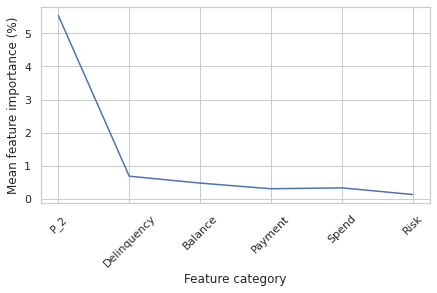

In [136]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(names, [p_2_mean, d_mean, b_mean, p_mean, s_mean, r_mean])
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel("Mean feature importance (%)")
plt.xlabel("Feature category")
plt.savefig("plots/220910_feature_importance_catboost_rowwise.pdf")
#fig.set_size_inches(6, 6)
